# Линейная регрессия в PySpark

<img src='https://i.ebayimg.com/images/g/6PAAAOSw93Bhplwj/s-l1200.jpg' width='300'/>

## Устанавливаем и импортируем пакеты

In [7]:
!pip install pyspark setuptools tqdm numpy matplotlib pandas seaborn


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log10
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import VectorAssembler, SQLTransformer, OneHotEncoder, StringIndexer, Imputer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.functions import vector_to_array
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import seaborn as sns
import matplotlib.pyplot as plt

from src.linear_regression import LinearRegressionEstimator

import warnings

warnings.filterwarnings("ignore")

seed = 666

## Подготовка данных

Датасет будет составлен из данных [American Community Survey](https://ceprdata.org/acs-uniform-data-extracts/acs-data/), опрашивающих жителей США об их домах/образовании/доходах. Будет рассмотрен 2005 год.

Исходный датасет состоит из большого числа переменных, мы же возьмем часть из них:
* `ybl_all`: В какое десятиление построен дом
* `acr`: Сколько акров (`<1 acre`, `1-<10 acres`, `10+ acres`)
* `ags`: Агрокультурные доходы с участка
* `bus`: Есть ли бизнес- или медицинский офис в здании
* `state`: Штат
* `bath`: Есть ли ванная
* `bdsp`: Кол-во спальных комнат
* `refr`: Есть ли холодильник
* `rmsp`: Кол-во комнат
* `rwat`: Есть ли горячая и холодная вода
* `stove`: Есть ли плита
* `tel`: Есть ли домашний телефон
* `toilet`: Есть ли туалет
* `kitchen`: Есть ли кухня
* `plumbing`: Есть ли водопровод
* `sink`: Есть ли раковина
* `hfl`: Тип обогревания (`No fuel used`, `Utility gas`, `Coal or coke`, `Electricity` и т.д.) 
* `jwtrns`: Как последний раз добирались на работу
* `value`: Какова, по вашему мнению, цена дома

Целевая для предсказания переменная: `value`

### Собираем датасет вместе

Так как датасет большой (>5Gb) и в нем много фичей, выделим только часть из них

In [9]:
needed_cols = ['ybl_all', 'acr', 'ags', 'bus', 'state', 'bath', 'bdsp', 'refr', 'rmsp', 'rwat', 'stove', 'tel', 'toilet', 'kitchen', 'plumbing', 'sink', 'hfl', 'jwtrns', 'value']

Разобьем на файлы 

(можно и пробегаться вручную по строкам, но в некоторых строковых значениях есть запятые --- лень правильно парсить :) )

In [10]:
rows_sum = 0
aggregated_df = pd.DataFrame()
for i, chunk_df in enumerate(pd.read_csv('data/cepr_acs_2005.csv', chunksize=100_000)):
    chunk_df[needed_cols].to_csv(f'data/splits/cepr_acs_2005_cropped_{i}.csv')

Считаем по файлам

In [11]:
spark = SparkSession.builder.appName('UsingLinearRegression').getOrCreate()
df = spark.read.option("header", True).csv("data/splits")
df.summary().show()

25/05/03 16:16:53 WARN Utils: Your hostname, artvyatkin resolves to a loopback address: 127.0.1.1; using 192.168.1.14 instead (on interface wlp4s0)
25/05/03 16:16:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/03 16:16:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/03 16:16:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/05/03 16:16:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , ybl_all, acr, ags, bus, state, bath, bdsp, refr, rmsp, rwat, stove, tel, toilet, kitchen, plumbing, sink, hfl, jwtrns, value
 Schema: _c0, ybl_all, acr, ags, bus, state, bath, bdsp, refr, rmsp, rwat, stove, 

+-------+-----------------+---------------+-----------+----------+--------------------+-------+----+------------------+----+------------------+----+-----+-------------------+------+-------------------+-------------------+----+--------------------+------+-----------------+
|summary|              _c0|        ybl_all|        acr|       ags|                 bus|  state|bath|              bdsp|refr|              rmsp|rwat|stove|                tel|toilet|            kitchen|           plumbing|sink|                 hfl|jwtrns|            value|
+-------+-----------------+---------------+-----------+----------+--------------------+-------+----+------------------+----+------------------+----+-----+-------------------+------+-------------------+-------------------+----+--------------------+------+-----------------+
|  count|          2964564|        2964564|    2497297|     62095|             2497297|2964564|   0|           2964564|   0|           2964564|   0|    0|            2878380|     0|

Видим, что некоторые значения почти пустые или совсем пустые. Возьмем только часть из первоначальных признаков

При этом возьмем только те строки, где целевая переменная не пуста

In [12]:
columns_with_many_values = ['ybl_all', 'acr', 'bus', 'state', 'bdsp', 'rmsp', 'tel', 'kitchen', 'plumbing', 'hfl', 'value']
df = df.select(columns_with_many_values)
df = SQLTransformer(statement="""
SELECT * FROM __THIS__
WHERE value IS NOT NULL
""").transform(df)
df.summary().show()

+-------+---------------+-----------+-------------------+-------+------------------+------------------+------------------+--------------------+-------------------+--------------------+-----------------+
|summary|        ybl_all|        acr|                bus|  state|              bdsp|              rmsp|               tel|             kitchen|           plumbing|                 hfl|            value|
+-------+---------------+-----------+-------------------+-------+------------------+------------------+------------------+--------------------+-------------------+--------------------+-----------------+
|  count|        2204817|    2123964|            2123964|2204817|           2204817|           2204817|           2193339|             2204817|            2204817|             2193339|          2204817|
|   mean|           NULL|       NULL|0.02034639005180879|   NULL|3.0893294090008205| 6.056607276422721|0.9849412243159859|  0.9964663733996971| 0.9959302744853654|                NULL|    

## Преобразовываем данные

Сразу разобьем на тестовую и тренировочную выборки

In [13]:
train_df, test_df = df.randomSplit(weights=[0.8, 0.2], seed=seed)

Преобразуем датасет с помощью `SQLTransformer`

Например, переведем значения целевой переменной по типу: `$10000-14999` -> `10000`

In [14]:
sql_transformer = SQLTransformer(statement="""
SELECT
    bus, 
    state,
    tel,
    kitchen,
    plumbing,
    hfl,
    SUBSTRING(ybl_all, 1, 4) AS ybl_all,
    CASE 
        WHEN acr = '<1 acre' then 0.5
        WHEN acr = '1-<10 acres' then 5.5
        WHEN acr = '10+ acres' then 10                    
    END as acr,
    SUBSTRING(bdsp, 1, 1) AS bdsp,
    SUBSTRING(rmsp, 1, 1) AS rmsp,
    CASE 
        WHEN value = '$1000000+' then 1000000
        WHEN value = 'Less than $ 10000' then 5000
        ELSE SUBSTRING(SUBSTRING_INDEX(value, '-', 1), 2)    
    END as value                                    
FROM __THIS__
""")
transformed_train_df = sql_transformer.transform(df)
transformed_train_df.head(5)

[Row(bus='0.0', state='Ohio', tel='1.0', kitchen='1', plumbing='1', hfl='Utility gas', ybl_all='1939', acr=Decimal('0.5'), bdsp='3', rmsp='8', value='20000'),
 Row(bus='0.0', state='Ohio', tel='1.0', kitchen='1', plumbing='1', hfl='Utility gas', ybl_all='1939', acr=Decimal('0.5'), bdsp='3', rmsp='8', value='20000'),
 Row(bus='0.0', state='Colorado', tel='1.0', kitchen='1', plumbing='1', hfl='Utility gas', ybl_all='1960', acr=Decimal('0.5'), bdsp='3', rmsp='5', value='250000'),
 Row(bus='0.0', state='Texas', tel='1.0', kitchen='1', plumbing='1', hfl='Utility gas', ybl_all='2000', acr=Decimal('0.5'), bdsp='4', rmsp='9', value='750000'),
 Row(bus='0.0', state='Texas', tel='1.0', kitchen='1', plumbing='1', hfl='Utility gas', ybl_all='2000', acr=Decimal('0.5'), bdsp='4', rmsp='9', value='750000')]

Нужно преобразовать некоторые типы

In [15]:
transformed_train_df.printSchema()

root
 |-- bus: string (nullable = true)
 |-- state: string (nullable = true)
 |-- tel: string (nullable = true)
 |-- kitchen: string (nullable = true)
 |-- plumbing: string (nullable = true)
 |-- hfl: string (nullable = true)
 |-- ybl_all: string (nullable = true)
 |-- acr: decimal(11,1) (nullable = true)
 |-- bdsp: string (nullable = true)
 |-- rmsp: string (nullable = true)
 |-- value: string (nullable = true)



In [16]:
class TypeChanger(Transformer):
    def __init__(self, coltype_map):
        super(TypeChanger, self).__init__()
        self.coltype_map = coltype_map

    def _transform(self, _df):
        _df = _df.select([col(c).cast(self.coltype_map[c]) if c in self.coltype_map else c for c in _df.columns])
        return _df


coltype_map = { 
    "bus": FloatType(), 
    "tel": FloatType(), 
    "kitchen": FloatType(), 
    "plumbing": FloatType(), 
    "ybl_all": FloatType(),
    "acr": FloatType(),
    "bdsp": FloatType(),
    "rmsp": FloatType(),
    "value": FloatType()
} 

type_changer = TypeChanger(coltype_map)
transformed_train_df = type_changer.transform(transformed_train_df)
transformed_train_df.printSchema()

root
 |-- bus: float (nullable = true)
 |-- state: string (nullable = true)
 |-- tel: float (nullable = true)
 |-- kitchen: float (nullable = true)
 |-- plumbing: float (nullable = true)
 |-- hfl: string (nullable = true)
 |-- ybl_all: float (nullable = true)
 |-- acr: float (nullable = true)
 |-- bdsp: float (nullable = true)
 |-- rmsp: float (nullable = true)
 |-- value: float (nullable = true)



In [17]:
transformed_train_df.summary().show()

+-------+-------------------+-------+------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|summary|                bus|  state|               tel|             kitchen|           plumbing|                 hfl|           ybl_all|               acr|              bdsp|              rmsp|             value|
+-------+-------------------+-------+------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|  count|            2123964|2204817|           2193339|             2204817|            2204817|             2193339|           2204817|           2123964|           2204817|           2204817|           2204817|
|   mean|0.02034639005180879|   NULL|0.9849412243159859|  0.9964663733996971| 0.9959302744853654|                NULL|1968.5853401892311| 2.0877

## Посмотрим на распределения значений

In [18]:
def get_fraction(_df, column, fraction_part=0.1):
    return _df.select(column).sort(column, ascending=True).sample(fraction=fraction_part, seed=seed).rdd.flatMap(lambda x: x).collect()

Распределение по штатам:

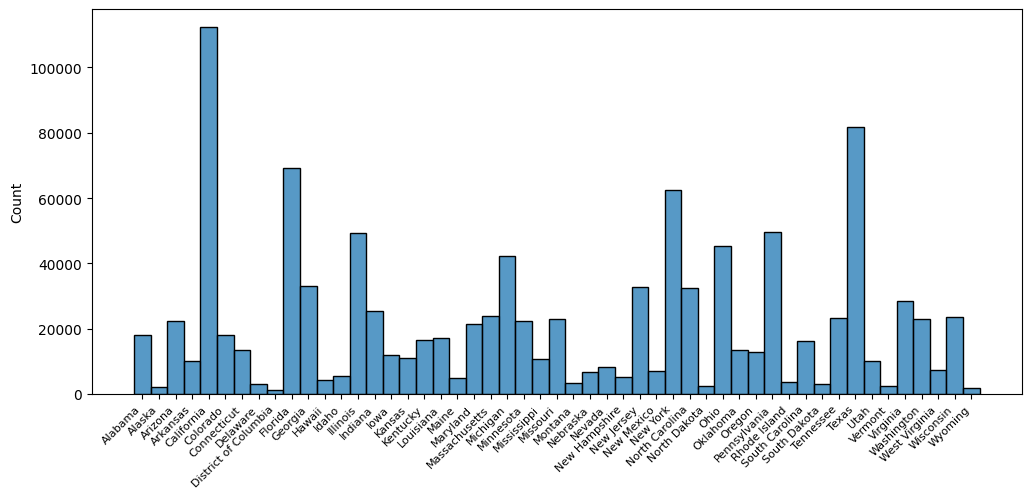

In [19]:
states_data = get_fraction(transformed_train_df, 'state', fraction_part=0.5)
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(states_data, ax=ax)
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.show()

Распределение по используемому топливу

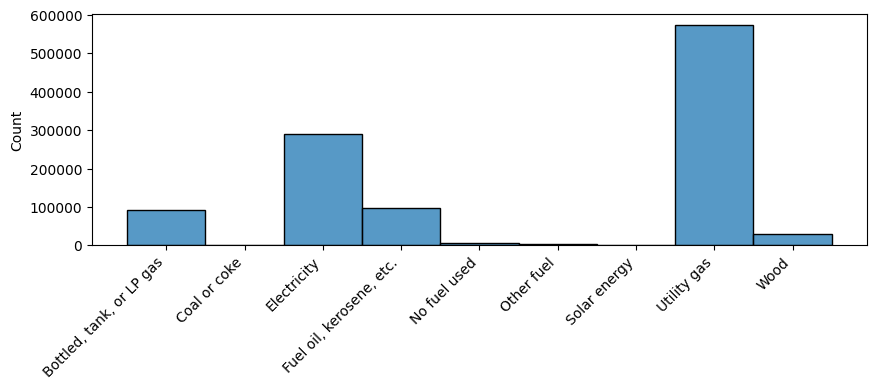

In [20]:
hfl_data = get_fraction(transformed_train_df, 'hfl', fraction_part=0.5)
fig, ax = plt.subplots(figsize=(10, 3))
sns.histplot(hfl_data, ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

Распределения по остальным признакам

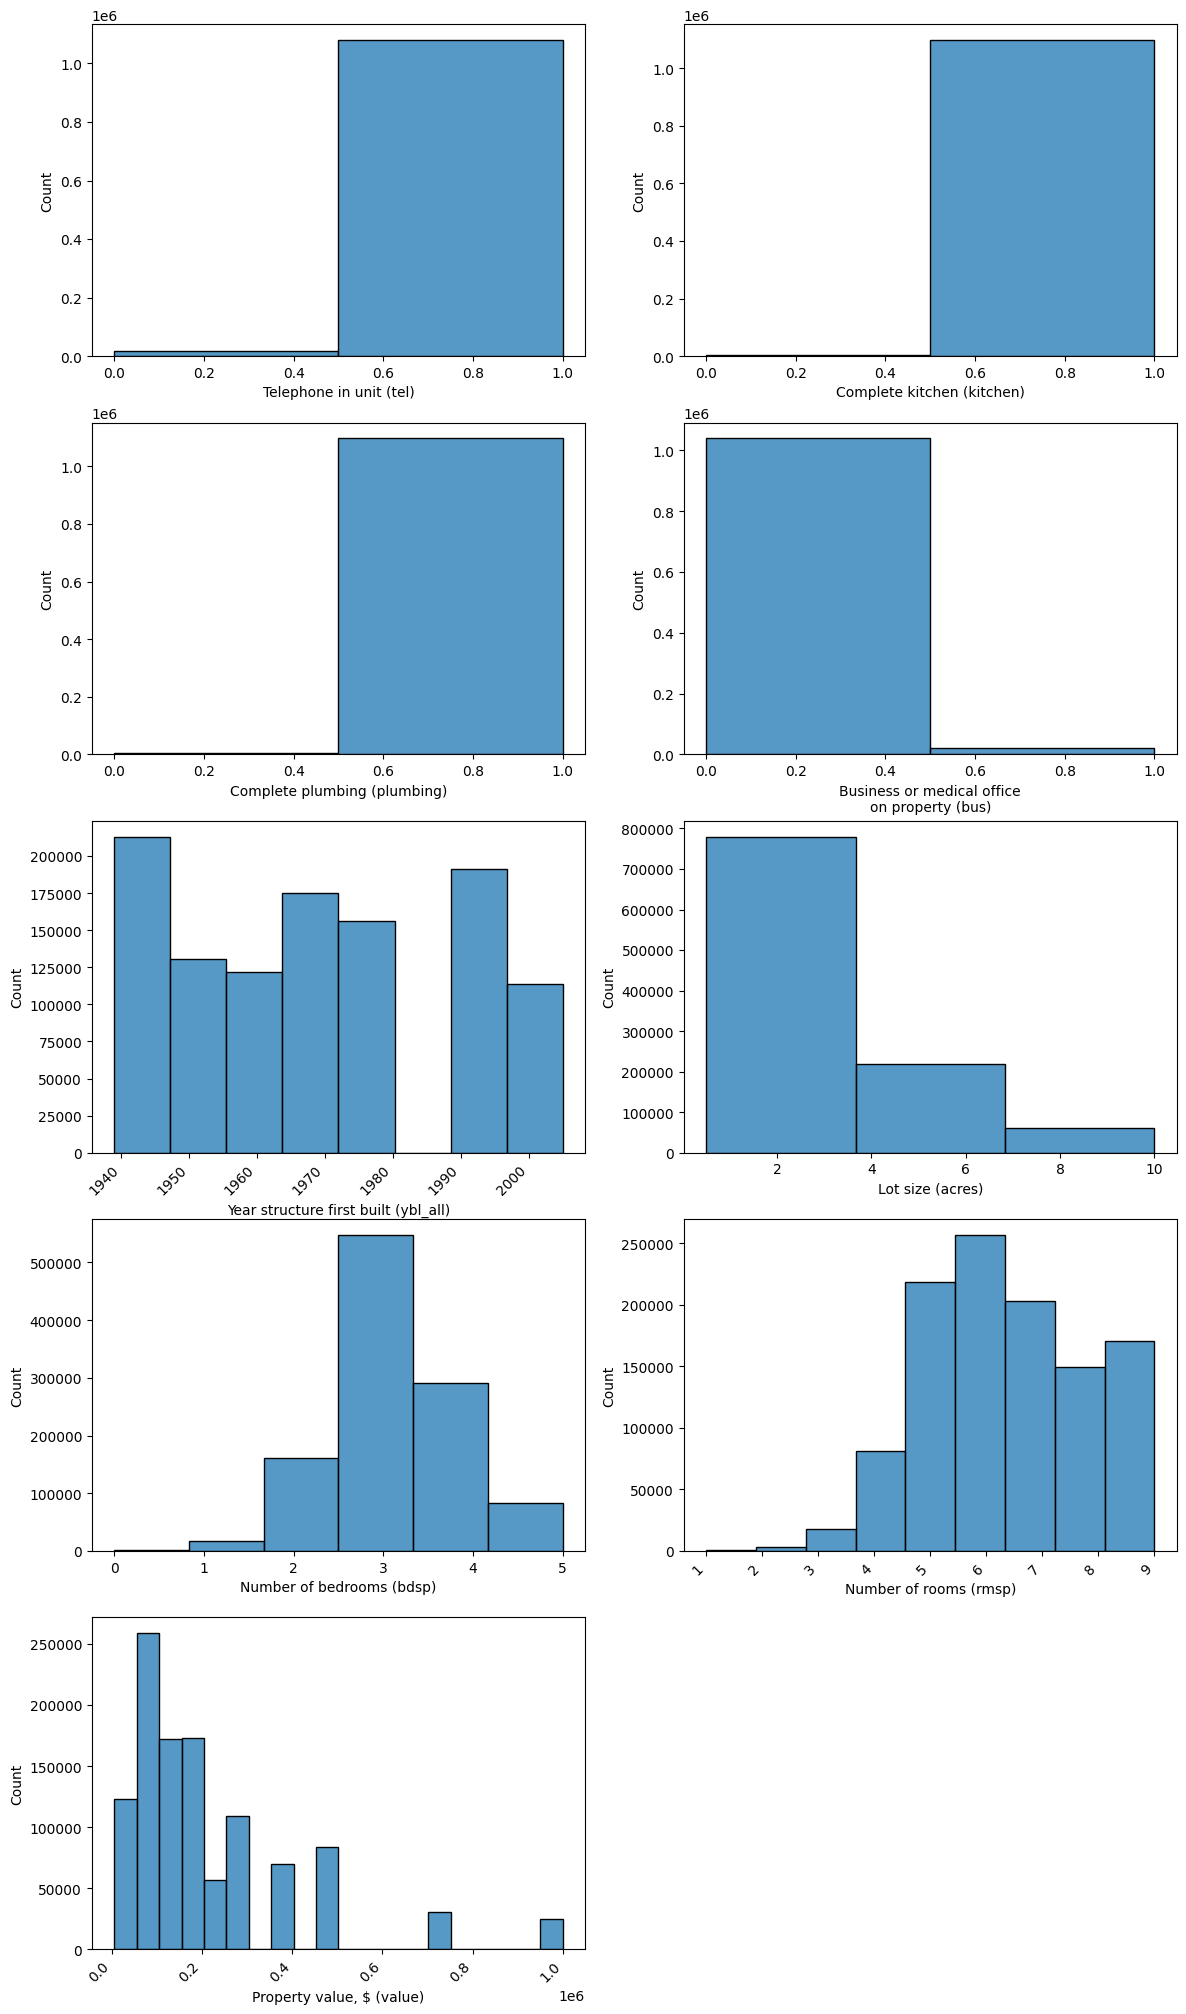

In [21]:
def add_hist(_df, _fig, column, x_label, subplot_indexes, nbins):
    _ax = sns.histplot(
        get_fraction(_df, column, fraction_part=0.5), 
        ax=_fig.add_subplot(*subplot_indexes),
        bins=nbins
    )
    if nbins > 6:
        plt.xticks(rotation=45, ha='right')
    _ax.set(xlabel=x_label, ylabel='Count')

fig = plt.figure()
fig.set_size_inches(14, 25)

for i, (column, label, nbins) in enumerate([
    ('tel', 'Telephone in unit (tel)', 2),
    ('kitchen', 'Complete kitchen (kitchen)', 2),
    ('plumbing', 'Complete plumbing (plumbing)', 2),
    ('bus', 'Business or medical office\non property (bus)', 2),
    ('ybl_all', 'Year structure first built (ybl_all)', 8),
    ('acr', 'Lot size (acres)', 3),
    ('bdsp', 'Number of bedrooms (bdsp)', 6),
    ('rmsp', 'Number of rooms (rmsp)', 9),
    ('value', 'Property value, $ (value)', 20),
]):
    add_hist(transformed_train_df, fig, column, label, (5, 2, i + 1), nbins)

Видим, что выбросов нет. Часть признаков (`tel`, `kitchen`, `plumbing`, `bus`) практически всегда имеют одно значение, однако оставим их. Возможно, например, отсутсвие кухни резко снижает стоимость дома.

Отстающие значения у `value` обусловлены тем, как эти данные собирались --- жильцы выбирали интервал значений, и интервалы с увеличением стоимости становились все больше. Попробуем прологорифмировать `value`:

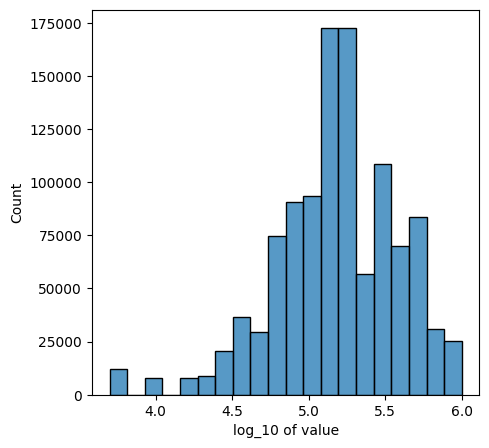

In [22]:
transformed_train_df = transformed_train_df.withColumn("log_value", log10(col("value")))

fig = plt.figure()
fig.set_size_inches(5, 5)
ax = sns.histplot(get_fraction(transformed_train_df, 'log_value', fraction_part=0.5), bins=20)
ax.set(xlabel='log_10 of value', ylabel='Count');

Ближе к нормальному, будем предсказывать `log_value`

## Корреляция между признаками

Преобразуем категориальные признаки с помощью `OneHotEncoder` и посмотрим на корреляцию между всеми признаками 

In [23]:
corr_string_indexer = StringIndexer(inputCols=["state", "hfl"], outputCols=['stateIndexCorr', "hflIndexCorr"]).setHandleInvalid('keep')
df_for_correlation = corr_string_indexer.fit(transformed_train_df).transform(transformed_train_df)

corr_one_hot_encoder = OneHotEncoder(inputCols=["stateIndexCorr", "hflIndexCorr"], outputCols=['stateOheCorr', "hflOheCorr"])
df_for_correlation = corr_one_hot_encoder.fit(df_for_correlation).transform(df_for_correlation)

Сначала глянем на корреляцию между признаками, не включающими `state` и `hfl`, где больше разнообразие категориальных значений

<Axes: >

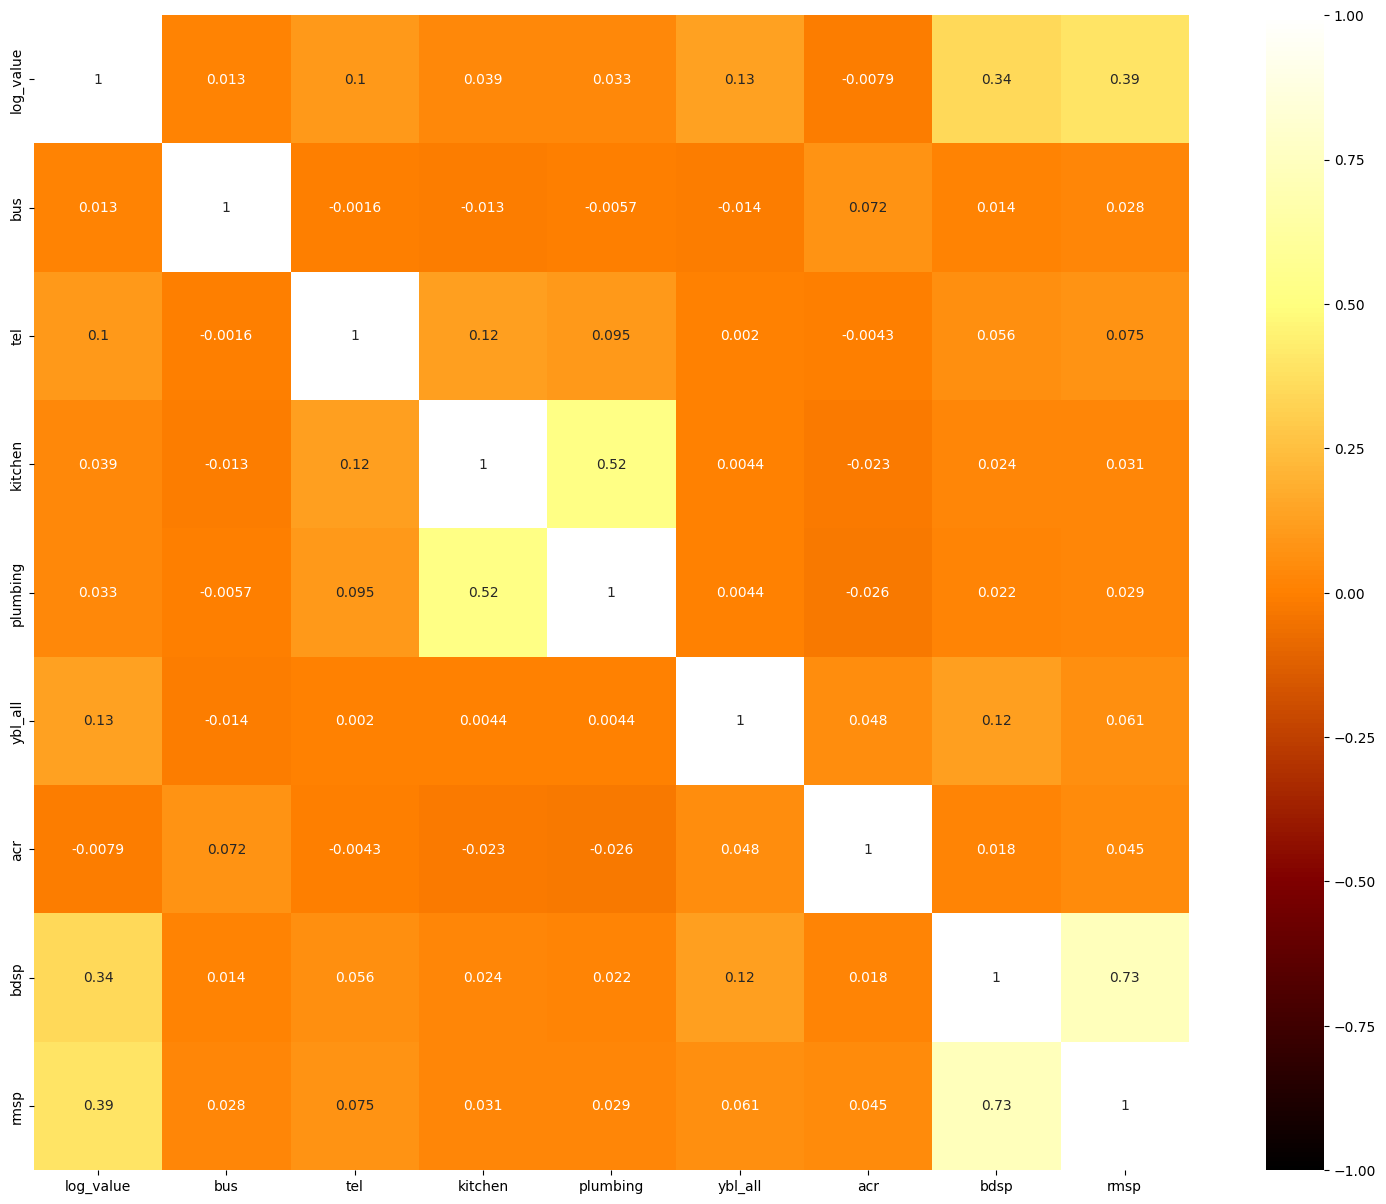

In [24]:
numeric_features = [
    'log_value', 
    'bus',
    'tel', 
    'kitchen',
    'plumbing', 
    'ybl_all', 
    'acr', 
    'bdsp', 
    'rmsp', 
]

pdf = (
    df_for_correlation
    .select(numeric_features)
    .sample(fraction=0.1, seed=seed)
    .toPandas()
)

fig = plt.figure()
fig.set_size_inches(20, 15)
sns.heatmap(
    pdf.corr(),
    vmin=-1, vmax=1, center=0,
    annot=True,
    cmap="afmhot",
    square=True,
)

Сильная корреляция заметна между `rmsp` и `bdsp`. Неудивительно --- число комнат и число спальных комнат должно коррелировать. Уберем в дальнейшем `bdsp` (спальные)

Посмотрим на корреляцию между всеми значениями

<Axes: >

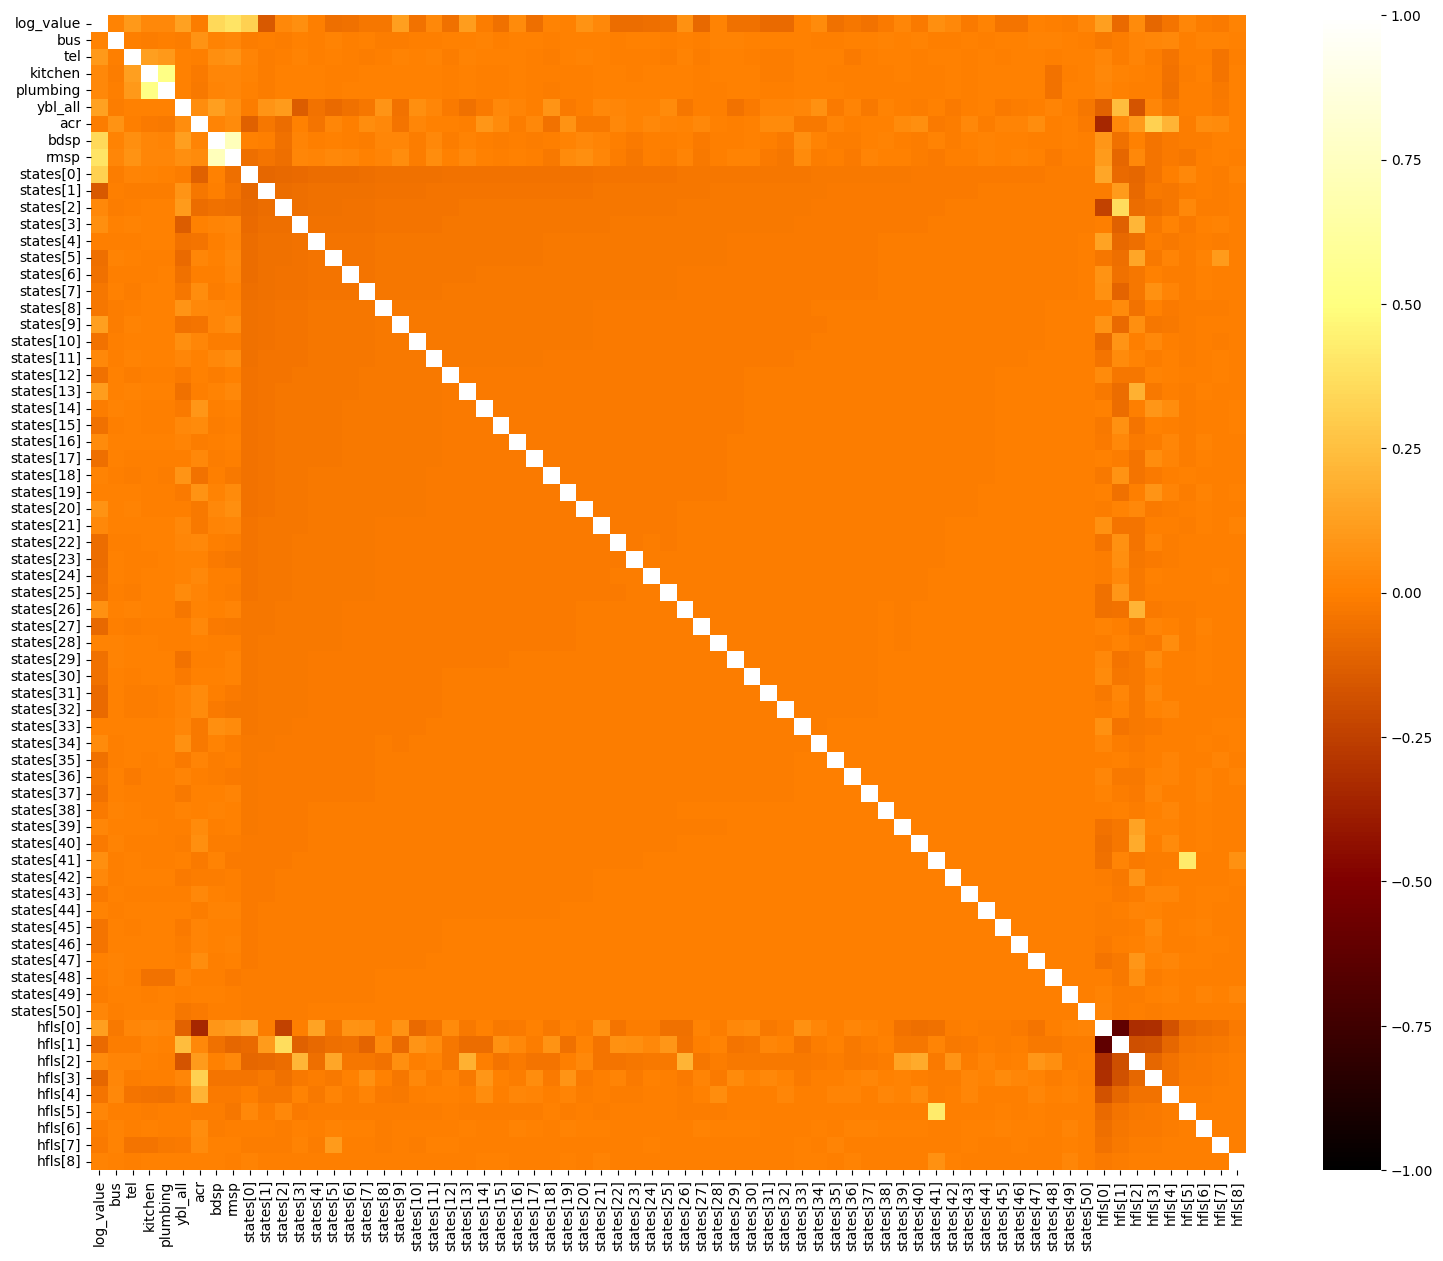

In [25]:
pdf = (
    df_for_correlation
        .select(numeric_features + ["hflOheCorr", "stateOheCorr"])
        .sample(fraction=0.1, seed=seed)
        .withColumn("hfls", vector_to_array("hflOheCorr"))
        .withColumn("states", vector_to_array("stateOheCorr"))
        .select(
            numeric_features + 
            [col("states")[i] for i in range(51)] +
            [col("hfls")[i] for i in range(9)]
        )
        .toPandas()
)

fig = plt.figure()
fig.set_size_inches(20, 15)

sns.heatmap(
    pdf.corr(),
    vmin=-1, vmax=1, center=0,
    cmap="afmhot",
    square=True,
)

Видим, что потенциально большая корреляция заметна между самими признками `hfl` (используемое топливо), а также между `hfl[0]` и `acr`. Посмотрим на это внимательнее

<Axes: >

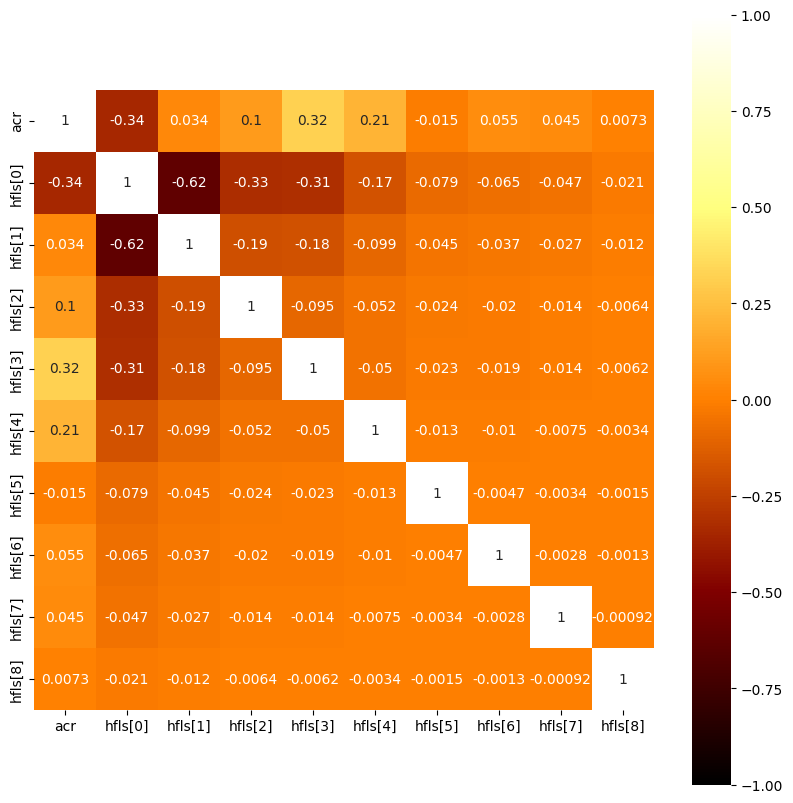

In [26]:
pdf = (
    df_for_correlation
        .select(['acr', 'hflOheCorr'])
        .sample(fraction=0.1, seed=seed)
        .withColumn("hfls", vector_to_array("hflOheCorr"))
        .select(
            ['acr'] + 
            [col("hfls")[i] for i in range(9)]
        )
        .toPandas()
)

fig = plt.figure()
fig.set_size_inches(10, 10)

sns.heatmap(
    pdf.corr(),
    vmin=-1, vmax=1, center=0,
    annot=True,
    cmap="afmhot",
    square=True,
)

Видим, что между `hfl[0]` и `acr` корреляция незначительная. Сильная корреляция между самими признаками `hfl` видна лишь из-за способа расчета корреляции, фактически между ними корреляцию не проследить 

## Финальные преобразования

Заполняем пустые значения и преобразовываем категориальные значения в числовые коды

In [27]:
class CustomNaFiller(Transformer):
    def __init__(self, fill_na_map):
        super(CustomNaFiller, self).__init__()
        self.fill_na_map = fill_na_map

    def _transform(self, _df):
        return _df.na.fill(self.fill_na_map)

na_filler = CustomNaFiller(fill_na_map={'hfl': 'Utility gas'})
transformed_train_df = na_filler.transform(transformed_train_df)

In [28]:
string_indexer = StringIndexer(inputCols=["state", "hfl"], outputCols=['stateIndex', "hflIndex"])
transformed_train_df = string_indexer.fit(transformed_train_df).transform(transformed_train_df)
transformed_train_df.head(5)

[Row(bus=0.0, state='Ohio', tel=1.0, kitchen=1.0, plumbing=1.0, hfl='Utility gas', ybl_all=1939.0, acr=0.5, bdsp=3.0, rmsp=8.0, value=20000.0, log_value=4.301029995663981, stateIndex=6.0, hflIndex=0.0),
 Row(bus=0.0, state='Ohio', tel=1.0, kitchen=1.0, plumbing=1.0, hfl='Utility gas', ybl_all=1939.0, acr=0.5, bdsp=3.0, rmsp=8.0, value=20000.0, log_value=4.301029995663981, stateIndex=6.0, hflIndex=0.0),
 Row(bus=0.0, state='Colorado', tel=1.0, kitchen=1.0, plumbing=1.0, hfl='Utility gas', ybl_all=1960.0, acr=0.5, bdsp=3.0, rmsp=5.0, value=250000.0, log_value=5.3979400086720375, stateIndex=21.0, hflIndex=0.0),
 Row(bus=0.0, state='Texas', tel=1.0, kitchen=1.0, plumbing=1.0, hfl='Utility gas', ybl_all=2000.0, acr=0.5, bdsp=4.0, rmsp=9.0, value=750000.0, log_value=5.8750612633917, stateIndex=1.0, hflIndex=0.0),
 Row(bus=0.0, state='Texas', tel=1.0, kitchen=1.0, plumbing=1.0, hfl='Utility gas', ybl_all=2000.0, acr=0.5, bdsp=4.0, rmsp=9.0, value=750000.0, log_value=5.8750612633917, stateInde

In [29]:
imputer = Imputer(
    inputCols=["bus", "tel", "acr"], 
    outputCols=["busImp", "telImp", "acrImp"],
    strategy='mode'
)
transformed_train_df = imputer.fit(transformed_train_df).transform(transformed_train_df)
transformed_train_df.select(
    ['busImp', 'state', 'telImp', 'kitchen', 'plumbing', 'hfl', 'ybl_all', 'acrImp', 'bdsp', 'rmsp', 'value']
).summary().show()

+-------+--------------------+-------+-------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              busImp|  state|             telImp|             kitchen|           plumbing|                 hfl|           ybl_all|            acrImp|              bdsp|              rmsp|             value|
+-------+--------------------+-------+-------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             2204817|2204817|            2204817|             2204817|            2204817|             2204817|           2204817|           2204817|           2204817|           2204817|           2204817|
|   mean|0.019600266144537165|   NULL| 0.9850196184082398|  0.9964663733996971| 0.9959302744853654|                NULL|1968.58534018923

## Пробуем регрессию

Выберем окончательные признаки, по которым будет идти предсказание и целевую переменную

In [30]:
feature_columns = ['busImp', 'stateOhe', 'telImp', 'kitchen', 'plumbing', 'hflOhe', 'ybl_all', 'acrImp', 'rmsp']
label_column = 'log_value'

Наконец, сделаем последние преобразования перед использованием регрессии: `OneHotEncoder`, `VectorAssembler`, `StandardScaler`

In [31]:
one_hot_encoder = OneHotEncoder(inputCols=["stateIndex", "hflIndex"], outputCols=['stateOhe', "hflOhe"])
assembler = VectorAssembler(inputCols=feature_columns, outputCol='rawFeatures')
scaler = StandardScaler(inputCol='rawFeatures', outputCol="features")

Соберем все в единый пайплайн и преобразуем им исходные данные для тренировки

In [32]:
pipeline = Pipeline(stages=
    [
        sql_transformer,
        type_changer,
        na_filler,
        string_indexer,
        imputer,
        one_hot_encoder,
        assembler,
        scaler,
    ]
)

pipline_model = pipeline.fit(train_df)
result_train_df = pipline_model.transform(train_df)
result_train_df = result_train_df.withColumn("log_value", log10(col("value")))
result_train_df.head(5)

25/05/03 16:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/03 16:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/03 16:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/03 16:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/03 16:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/03 16:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/03 16:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/03 16:20:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/03 16:20:16 WARN RowBasedKeyValueBatch: Calling spill() on

[Row(bus=None, state='Alaska', tel=1.0, kitchen=1.0, plumbing=1.0, hfl='Wood', ybl_all=1939.0, acr=None, bdsp=5.0, rmsp=9.0, value=125000.0, stateIndex=48.0, hflIndex=4.0, busImp=0.0, telImp=1.0, acrImp=0.5, stateOhe=SparseVector(50, {48: 1.0}), hflOhe=SparseVector(8, {4: 1.0}), rawFeatures=SparseVector(65, {49: 1.0, 51: 1.0, 52: 1.0, 53: 1.0, 58: 1.0, 62: 1939.0, 63: 0.5, 64: 9.0}), features=SparseVector(65, {49: 22.4996, 51: 8.2371, 52: 16.8788, 53: 15.6844, 58: 6.172, 62: 94.9535, 63: 0.18, 64: 5.6273}), log_value=5.096910013008056),
 Row(bus=None, state='Alaska', tel=1.0, kitchen=1.0, plumbing=1.0, hfl='Wood', ybl_all=1939.0, acr=None, bdsp=5.0, rmsp=9.0, value=125000.0, stateIndex=48.0, hflIndex=4.0, busImp=0.0, telImp=1.0, acrImp=0.5, stateOhe=SparseVector(50, {48: 1.0}), hflOhe=SparseVector(8, {4: 1.0}), rawFeatures=SparseVector(65, {49: 1.0, 51: 1.0, 52: 1.0, 53: 1.0, 58: 1.0, 62: 1939.0, 63: 0.5, 64: 9.0}), features=SparseVector(65, {49: 22.4996, 51: 8.2371, 52: 16.8788, 53: 1

Вообще можно использовать кросс-валидацию, но у меня ноутбук умирает :(

In [33]:
# linear_regression = LinearRegression(labelCol=label_column) 
# grid = ParamGridBuilder().addGrid(linear_regression.regParam, [0.001, 0.01, 0.1, 1, 10]).build()
# cv_evaluator = RegressionEvaluator(labelCol=label_column, metricName="r2")
# cv = CrossValidator(estimator=linear_regression, estimatorParamMaps=grid, evaluator=cv_evaluator)
# cvModel = cv.fit(result_train_df)
# print(cvModel.avgMetrics)
# print(cvModel.bestModel)
# print(cvModel.bestModel.getRegParam())

Попробуем просто ручками преребрать параметры регуляризации

In [34]:
mini_train_df, val_df = result_train_df.randomSplit(weights=[0.8, 0.2], seed=seed)
r2_evaluator = RegressionEvaluator(labelCol=label_column, metricName="r2")

for regParam in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
    lr = LinearRegression(labelCol=label_column, regParam=regParam)
    lr_current_model = lr.fit(mini_train_df)
    current_prediction_df = lr_current_model.transform(val_df)
    print(f'regParam = {regParam}. R^2: {r2_evaluator.evaluate(current_prediction_df):.3f}')

25/05/03 16:20:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


regParam = 1e-05. R^2: 0.427


regParam = 0.0001. R^2: 0.427


regParam = 0.001. R^2: 0.427


regParam = 0.01. R^2: 0.426


regParam = 0.1. R^2: 0.410


regParam = 1. R^2: 0.222


regParam = 10. R^2: 0.036


<img src="https://disgustingmen.com/wp-content/uploads/2019/05/daenerys-mad-queen.jpeg" width=300 />

Ну, плохой результат тоже результат)

Возьмем лучшую модель

In [35]:
total_linear_regression = LinearRegression(labelCol=label_column, regParam=0.001) 
lr_model = total_linear_regression.fit(result_train_df)
lr_model

LinearRegressionModel: uid=LinearRegression_58baefa9c196, numFeatures=65

In [36]:
lr_model.coefficients

DenseVector([0.0033, 0.0826, -0.0895, -0.0071, -0.0051, -0.0529, -0.0319, -0.0526, -0.0394, -0.0445, 0.018, -0.0435, -0.0126, -0.0462, 0.0246, -0.0254, -0.0449, -0.0043, -0.0439, -0.0118, -0.0218, 0.0022, -0.0102, -0.0474, -0.0448, -0.0425, -0.038, 0.0117, -0.0458, -0.0069, -0.0386, -0.0406, -0.0435, -0.0407, -0.0209, 0.003, -0.0346, -0.0211, -0.0304, -0.0192, 0.0001, -0.0133, 0.02, 0.0071, -0.0143, -0.0052, -0.0232, -0.0244, -0.006, -0.0058, -0.0125, 0.0195, 0.0035, 0.0028, 0.0125, -0.0159, -0.0088, -0.0288, -0.0189, -0.0023, -0.004, -0.0063, 0.0567, 0.0338, 0.1486])

In [37]:
lr_model.intercept

-1.0208264301241605

In [38]:
transformed_test_df = pipline_model.transform(test_df)
transformed_test_df = transformed_test_df.withColumn("log_value", log10(col("value")))
prediction_df = lr_model.transform(transformed_test_df)
prediction_df.select(['prediction', 'log_value']).head(10)

[Row(prediction=5.2995239948638275, log_value=5.698970004336019),
 Row(prediction=5.392464335975883, log_value=5.8750612633917),
 Row(prediction=5.250969461914998, log_value=5.698970004336019),
 Row(prediction=5.392464335975883, log_value=5.698970004336019),
 Row(prediction=5.4854046770879386, log_value=6.0),
 Row(prediction=5.039565072311359, log_value=5.3979400086720375),
 Row(prediction=5.170094343841591, log_value=5.301029995663981),
 Row(prediction=5.170094343841591, log_value=5.698970004336019),
 Row(prediction=5.225966312909094, log_value=5.477121254719663),
 Row(prediction=5.50478733624526, log_value=4.778151250383644)]

In [39]:
rmse_evaluator = RegressionEvaluator(labelCol=label_column, metricName="rmse")
print(f'RMSE: {rmse_evaluator.evaluate(prediction_df):.3f}')

RMSE: 0.310


In [40]:
print(f'R^2: {r2_evaluator.evaluate(prediction_df):.3f}')

R^2: 0.424


Ну и попробуем мою модель)

In [41]:
my_linear_regression = LinearRegressionEstimator(labelCol='log_value')
my_lr_model = my_linear_regression.fit(result_train_df)
my_lr_model.coefficients

25/05/03 16:24:39 WARN BlockManager: Task 1073 already completed, not releasing lock for rdd_656_0
100%|██████████| 100/100 [04:05<00:00,  2.46s/it]                               


array([7.43508087e+296, 1.77982102e+297, 1.49928148e+297, 1.36843786e+297,
       1.28740597e+297, 1.14114323e+297, 1.14244024e+297, 1.09177198e+297,
       1.04864406e+297, 9.32747597e+296, 9.23003304e+296, 9.24416919e+296,
       8.62576126e+296, 8.12101213e+296, 7.83721697e+296, 7.78503667e+296,
       7.76099279e+296, 7.73831947e+296, 7.67663386e+296, 7.60966701e+296,
       7.53130872e+296, 7.43144732e+296, 6.83739771e+296, 6.76183434e+296,
       6.58885702e+296, 6.49623587e+296, 6.48459433e+296, 5.85655944e+296,
       5.85575371e+296, 5.77313458e+296, 5.55755408e+296, 5.30460843e+296,
       5.28499178e+296, 5.17632391e+296, 5.07669460e+296, 4.63772969e+296,
       4.28033989e+296, 4.24959275e+296, 4.18676776e+296, 3.81095481e+296,
       3.67312115e+296, 3.60104750e+296, 3.34762795e+296, 3.06877252e+296,
       2.93111296e+296, 2.83232961e+296, 2.75544962e+296, 2.56373449e+296,
       2.49431854e+296, 2.35076102e+296, 2.24105022e+296, 4.28182305e+298,
       8.87595028e+298, 8

In [42]:
my_lr_model.intercept

np.float64(5.276372258594623e+297)

In [43]:
my_prediction_df = my_lr_model.transform(transformed_test_df)
r2_evaluator.evaluate(my_prediction_df)

-inf

**Важность регуляризации!**

(на более маленьких тестах мой класс справляется)